In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import sys
sys.path.insert(0, "/home/ninarell/OneDrive/WF_GAN_FOR_GLASSES/B_GEN/bgflow")
import bgflow

In [3]:
from  bgflow.distribution.energy import LennardJonesPotentialPPP


n_particles = 10
dim = 3
dim_ics = n_particles * dim
side = 3.
temperature=1.0
rm = 2**(1./6.)
target = LennardJonesPotentialPPP(dim = dim_ics, n_particles = n_particles, side = side, oscillator = False, rm=rm)

#from  bgflow.distribution.energy import DoubleWellEnergy
#target = DoubleWellEnergy(dim)

In [4]:
from bgflow import IterativeSampler, SamplerStep, MCMCStep, SamplerState, GaussianProposal, GaussianMCMCSampler
from bgflow import DoubleWellEnergy
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [5]:
def plot_energy(coordinates, target):
    xs = torch.Tensor(coordinates)
    xs = xs.view(-1,n_particles,dim)
    energy = target.energy(xs).detach().numpy()
    
    x=np.arange(1,len(energy)+1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    #plt.yscale("log")

    plt.plot(x, energy)

    plt.subplot(1, 2, 2)
    counts, bins = np.histogram(energy, density=True)
    plt.yscale("log")
    plt.stairs(counts, bins)

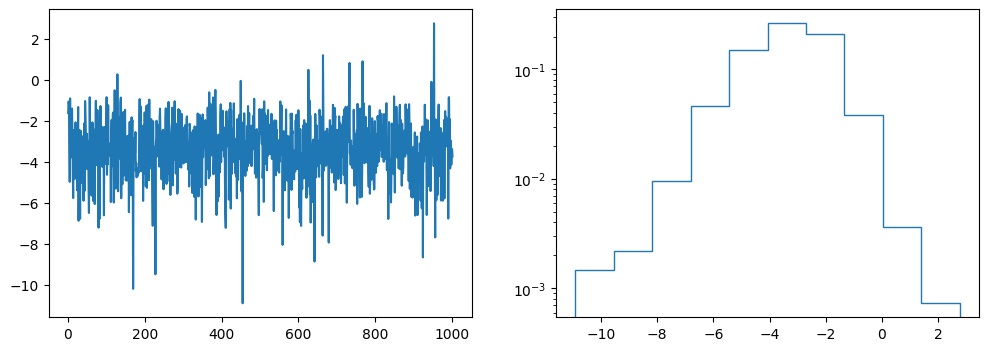

In [6]:
from glob import glob 
fnames = glob('/home/ninarell/OneDrive/WF_GAN_FOR_GLASSES/LJ_CRYSTAL/T_0.700_box/dumplin/dump.npt_nose_T1.0_P0.*.lammpstrj')
arrays = [np.loadtxt(f, skiprows=9)[:,2:5] for f in fnames]
coordinates = np.array(arrays)
plot_energy(coordinates, target)

In [7]:
def constraint(x):
    return torch.where((abs(x) > side).clone().detach(), x - 2 * side * torch.sign(x) * torch.floor(abs(x)/side), x)

In [8]:
#target.energy(torch.Tensor(coordinates[10]).view(-1,n_particles,dim))

In [9]:
init_state = torch.Tensor(coordinates[10]) #zeros(10,3)

mcsampler = GaussianMCMCSampler(target, init_state=init_state, temperature=temperature, box_constraint=constraint, noise_std=0.15)
#mcsampler = GaussianMCMCSampler(target, init_state=init_state, temperature=temperature, noise_std=0.1)

In [18]:
data = mcsampler.sample(20000)
data = data.view(-1,dim_ics)

In [19]:
coordinates[10]

array([[ 2.14891614, -1.53916028, -0.53199933],
       [ 1.11018855, -0.38409949, -0.59236168],
       [-1.13275815,  1.31500597,  2.49969276],
       [ 0.2585521 , -0.35805006,  2.74546834],
       [ 2.25381812,  1.65228018, -1.52098261],
       [ 0.68332476, -2.32015419,  2.55499543],
       [-0.77126002, -2.81309859, -2.11845444],
       [-2.48480992, -1.56723946,  2.15251997],
       [-0.60152075,  1.74709903,  1.69724273],
       [-1.46445083, -1.7325831 , -0.88612118]])

In [20]:
data[0].view(-1,10,3)

tensor([[[-1.4879,  2.3716, -1.1829],
         [-1.7031,  0.9912, -1.9275],
         [ 2.9368,  1.4033, -1.7848],
         [ 0.4161, -2.3216,  2.5833],
         [ 0.4257, -0.4019,  2.0755],
         [ 0.2104,  2.9489, -2.7155],
         [-2.5266, -0.6420,  1.0906],
         [-2.4486,  2.9877,  0.1723],
         [ 1.8364,  2.0032, -1.6050],
         [ 1.9526, -0.7504, -1.0229]]])

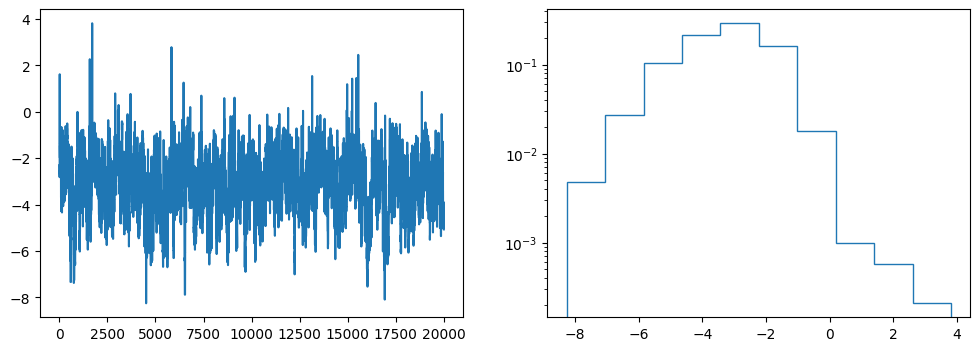

In [21]:
plot_energy(data, target)

In [22]:
xs = torch.Tensor(coordinates)
xs = xs.view(-1,10,3)
energy = target.energy(xs).detach().numpy()
target.energy(xs).detach().numpy().mean()

-3.3608181

In [23]:
xs = torch.Tensor(data)
xs = xs.view(-1,10,3)
energy2 = target.energy(xs).detach().numpy()
print(energy2[energy2>1e8], np.argwhere(energy2>1e8))

[] []


In [24]:
data[484:485]

tensor([[ 1.9949, -2.3130, -1.9944,  1.4737, -2.7068,  1.2715,  0.8168, -0.7245,
         -1.5406,  2.7130,  1.4842, -2.6721,  2.0875, -1.3553, -0.4496, -2.3757,
         -2.1842,  1.4425,  0.4599, -2.9044, -0.2115,  1.8165,  0.2317, -0.6172,
         -0.7189, -1.7141, -0.1101,  1.0720, -1.6455,  2.2750]])

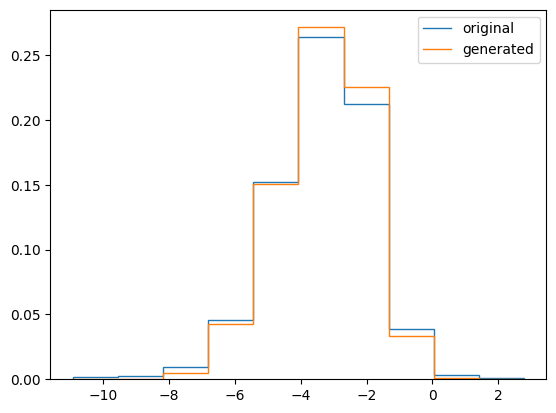

In [26]:
counts, bins = np.histogram(energy, density=True)
counts2, bins2 = np.histogram(energy2, bins=bins, density=True)
#plt.yscale("log")
plt.stairs(counts, bins, label='original')
plt.stairs(counts2, bins2, label='generated')
plt.legend()
plt.show()